In [1]:
install.packages("quantmod")
install.packages("tseries")
install.packages("forecast")
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘quadprog’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




In [ ]:
library(quantmod)
library(tseries)
library(forecast)
library(reshape2)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [ ]:
getSymbols("^GSPC", from = "2000-01-01", to = "2023-12-31")
sp500_prices <- Ad(GSPC)
log_returns <- diff(log(coredata(sp500_prices)))

[1] "GSPC"

ADF testi

In [ ]:
adf_test <- adf.test(log_returns, alternative = "stationary")
cat("\nADF Test Result: p-value =", adf_test$p.value, "\n")
if (adf_test$p.value < 0.05) {
  cat("Data is stationary (reject H0).\n")
} else {
  cat("Data is not stationary (fail to reject H0).\n")
}

Warning message in adf.test(log_returns, alternative = "stationary"):
“p-value smaller than printed p-value”



ADF Test Result: p-value = 0.01 
Data is stationary (reject H0).


ACF ve PACF grafikleri

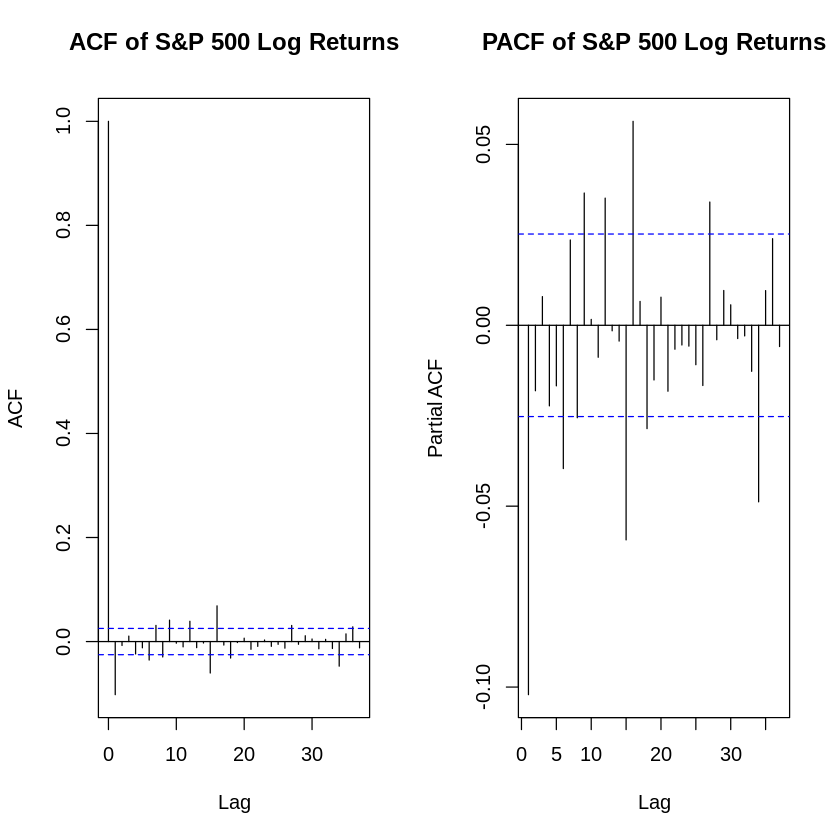

In [ ]:
par(mfrow = c(1, 2)) # Tek pencerede iki grafik
acf(log_returns, main = "ACF of S&P 500 Log Returns")
pacf(log_returns, main = "PACF of S&P 500 Log Returns")
par(mfrow = c(1, 1)) # Orijinal görünüme dön

Tüm (p, q) kombinasyonlarını deneyerek AIC/BIC karşılaştırması

In [ ]:
max_p <- 5 # AR derecesi için maksimum değer
max_q <- 5 # MA derecesi için maksimum değer

results <- data.frame(Model = character(), AIC = numeric(), BIC = numeric(), stringsAsFactors = FALSE)

for (p in 0:max_p) {
  for (q in 0:max_q) {
    # ARIMA modeli
    tryCatch({
      model <- Arima(log_returns, order = c(p, 0, q))
      # Model sonuçları
      results <- rbind(results, data.frame(
        Model = sprintf("ARIMA(%d,0,%d)", p, q),
        AIC = AIC(model),
        BIC = BIC(model)
      ))
    }, error = function(e) { NULL }) # Hata durumunda devam ediyor
  }
}

AIC ve BIC'ye göre en iyi 5 sonuç

In [ ]:
results <- results[order(results$AIC, results$BIC), ]
cat("\nTop 5 Models by AIC and BIC:\n")
print(head(results, 5))


Top 5 Models by AIC and BIC:
          Model       AIC       BIC
36 ARIMA(5,0,5) -35971.57 -35891.10
28 ARIMA(4,0,3) -35952.30 -35891.95
23 ARIMA(3,0,4) -35951.29 -35890.94
35 ARIMA(5,0,4) -35950.74 -35876.98
30 ARIMA(4,0,5) -35949.96 -35876.20


auto.arima denemesi

In [ ]:
cat("\nAuto ARIMA Model Suggestion:\n")
auto_model <- auto.arima(log_returns)
print(summary(auto_model))
cat(sprintf("Suggested Model: ARIMA(%d, %d, %d)\n",
            auto_model$arma[1], auto_model$arma[6], auto_model$arma[2]))


Auto ARIMA Model Suggestion:
Series: log_returns 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.1020
s.e.   0.0128

sigma^2 = 0.0001517:  log likelihood = 17974.84
AIC=-35945.68   AICc=-35945.68   BIC=-35932.27

Training set error measures:
                       ME       RMSE         MAE MPE MAPE      MASE
Training set 0.0002168148 0.01231572 0.008185518 NaN  Inf 0.6703357
                     ACF1
Training set -0.001982893
Suggested Model: ARIMA(1, 0, 0)


En iyi modeli seçme

In [ ]:
best_model_order <- as.numeric(strsplit(gsub("ARIMA\\((.*)\\)", "\\1", results$Model[1]), ",")[[1]])
best_model <- Arima(log_returns, order = best_model_order)

In [ ]:
cat("\nBest Model Diagnostics:\n")
print(summary(best_model))


Best Model Diagnostics:
Series: log_returns 
ARIMA(5,0,5) with non-zero mean 

Coefficients:
          ar1      ar2      ar3      ar4     ar5     ma1     ma2     ma3
      -0.8245  -0.2977  -0.5957  -0.1058  0.4359  0.7257  0.2019  0.5673
s.e.   0.1756   0.2074   0.2110   0.2091  0.1142  0.1739  0.1891  0.1913
         ma4      ma5   mean
      0.0208  -0.4817  2e-04
s.e.  0.1920   0.0991  1e-04

sigma^2 = 0.0001508:  log likelihood = 17997.78
AIC=-35971.57   AICc=-35971.52   BIC=-35891.1

Training set error measures:
                        ME       RMSE         MAE MPE MAPE      MASE
Training set -3.777135e-07 0.01226892 0.008173397 NaN  Inf 0.6693431
                     ACF1
Training set -0.001886234



	Ljung-Box test

data:  Residuals from ARIMA(5,0,5) with non-zero mean
Q* = 15.979, df = 3, p-value = 0.001145

Model df: 10.   Total lags used: 13



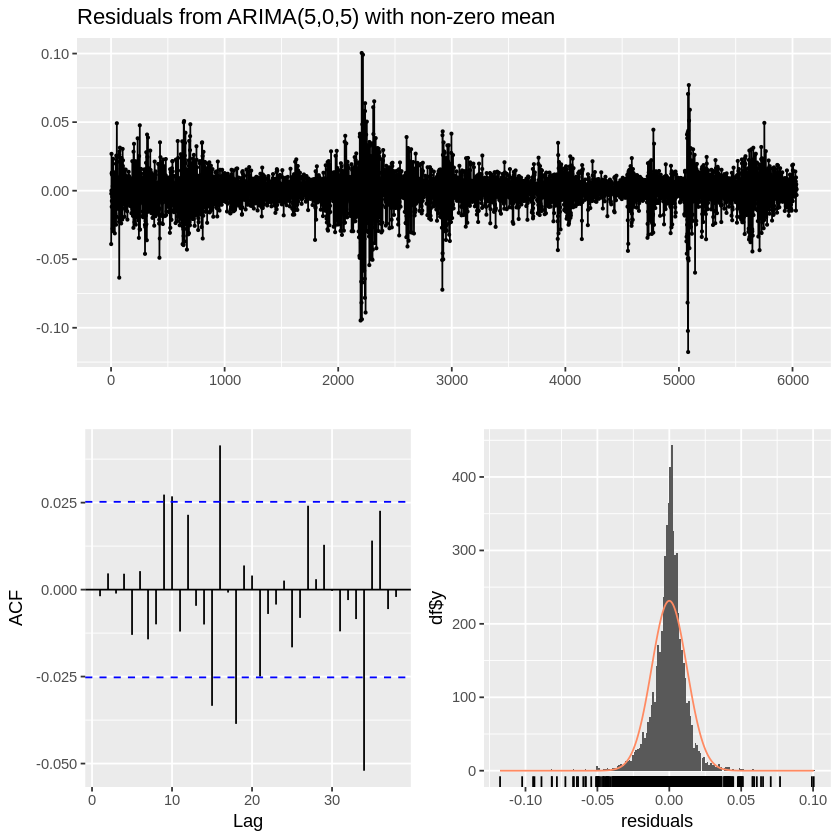

In [ ]:
checkresiduals(best_model)

Ljung-Box testi

In [ ]:
ljung_box_test <- Box.test(residuals(best_model), lag = 10, type = "Ljung-Box")
cat(sprintf("Ljung-Box Test p-value: %.5f\n", ljung_box_test$p.value))
if (ljung_box_test$p.value > 0.05) {
  cat("Residuals are not autocorrelated (fail to reject H0).\n")
} else {
  cat("Residuals show autocorrelation (reject H0).\n")
}

Ljung-Box Test p-value: 0.27363
Residuals are not autocorrelated (fail to reject H0).


1,0,0 values for the ARIMA

In [ ]:

arima_100 <- Arima(log_returns, order = c(1, 0, 0))


arima_100_metrics <- accuracy(arima_100)
arima_100_acf1 <- acf(residuals(arima_100), plot = FALSE)$acf[2]


arima_100_aic <- AIC(arima_100)
arima_100_bic <- BIC(arima_100)


arima_100_results <- data.frame(
  Model = "ARIMA(1,0,0)",
  AIC = arima_100_aic,
  BIC = arima_100_bic,
  ME = arima_100_metrics[1, "ME"],
  RMSE = arima_100_metrics[1, "RMSE"],
  MAE = arima_100_metrics[1, "MAE"],
  MPE = arima_100_metrics[1, "MPE"],
  MAPE = arima_100_metrics[1, "MAPE"],
  MASE = arima_100_metrics[1, "MASE"],
  ACF1 = arima_100_acf1
)



results for ARIMA(1,0,0)

In [ ]:
arima_100_results[1,]

,Model,AIC,BIC,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"ARIMA(1,0,0)",-35945.56,-35925.45,-1.999555e-07,0.0123138,0.008170173,NaN,Inf,0.6690791,-0.001699197


emprirical dist.

In [ ]:
library(reshape2)

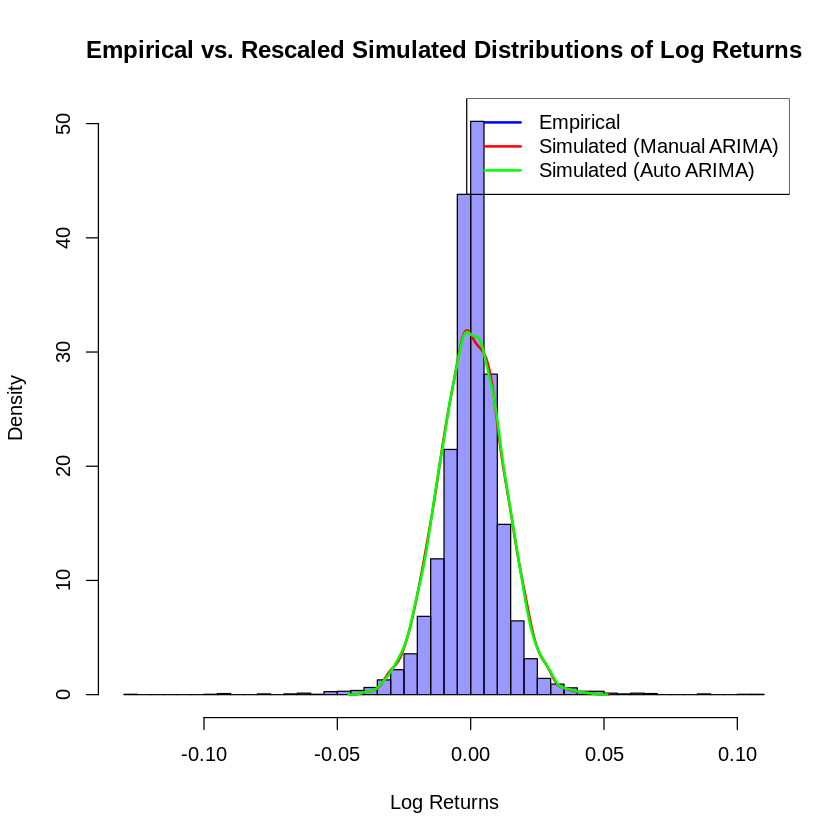

In [ ]:

n <- length(log_returns)


set.seed(123)
sim_manual <- arima.sim(model = list(order = c(5, 0, 5),
                                     ar = best_model$coef[grep("ar", names(best_model$coef))],
                                     ma = best_model$coef[grep("ma", names(best_model$coef))]), n = n)

set.seed(123)
auto_order <- auto_model$arma
sim_auto <- arima.sim(model = list(order = c(auto_order[1], auto_order[6], auto_order[2]),
                                   ar = auto_model$coef[grep("ar", names(auto_model$coef))],
                                   ma = auto_model$coef[grep("ma", names(auto_model$coef))]), n = n)


sim_manual <- scale(sim_manual) * sd(log_returns) + mean(log_returns)
sim_auto <- scale(sim_auto) * sd(log_returns) + mean(log_returns)

hist(log_returns, breaks = 50, probability = TRUE, main = "Empirical vs. Rescaled Simulated Distributions of Log Returns",
     xlab = "Log Returns", col = rgb(0, 0, 1, 0.4))
lines(density(sim_manual), col = "red", lwd = 2)
lines(density(sim_auto), col = "green", lwd = 2)
legend("topright", legend = c("Empirical", "Simulated (Manual ARIMA)", "Simulated (Auto ARIMA)"),
       col = c("blue", "red", "green"), lty = 1, lwd = 2)
